In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import mne
import pathlib
import sklearn
import hdbscan
import seaborn as sns

import pycrostates
from proof_of_consept import unit_normalize

In [2]:
data_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro")
file = data_folder / "sub-001_ses-t1_task-resteyesc_eeg.edf"
processed_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro_cleaned")
processed_file = processed_folder / "sub-001_ses-t1_task-resteyesc_desc-epochs_eeg.set"

raw = mne.io.read_raw_edf(file, preload=True)
raw.set_montage('biosemi64')
cleaned = mne.io.read_epochs_eeglab(processed_file)

raw_highpass = raw.copy().filter(l_freq=0.5, h_freq=None)
raw_lowpass = raw_highpass.copy().filter(l_freq=None, h_freq=40)
raw_down_sampled = raw_lowpass.copy().resample(sfreq=256)

Extracting EDF parameters from C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro\sub-001_ses-t1_task-resteyesc_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 245759  =      0.000 ...   239.999 secs...


Extracting parameters from C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro_cleaned\sub-001_ses-t1_task-resteyesc_desc-epochs_eeg.set...
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 6759 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 339 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


In [242]:
gfp_data_cleaned = pycrostates.preprocessing.extract_gfp_peaks(cleaned, min_peak_distance=1)

In [243]:
print(gfp_data_cleaned.get_data().shape)

(64, 5794)


In [244]:
normalized = unit_normalize(gfp_data_cleaned.get_data().T)
activation = normalized.dot(normalized.T)
absolute_cosine_matrix = np.abs(activation)
#np.fill_diagonal(absolute_cosine_matrix, 0)

In [245]:
cluster = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=10, min_samples=10)
cluster.fit(absolute_cosine_matrix)

HDBSCAN(metric='precomputed', min_cluster_size=10, min_samples=10)

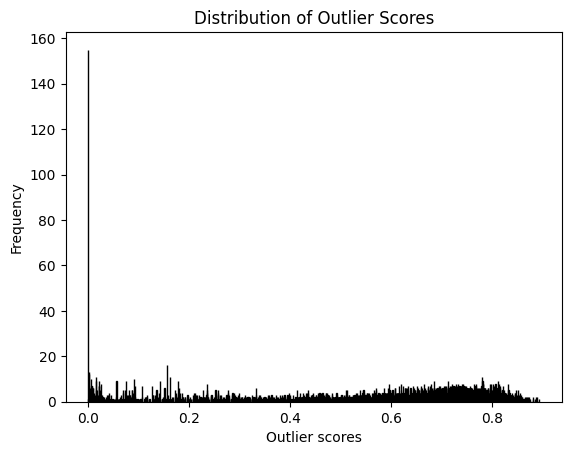

In [246]:
plt.hist(cluster.outlier_scores_, bins=3500, edgecolor='k')
plt.xlabel('Outlier scores')
plt.ylabel('Frequency')
plt.title('Distribution of Outlier Scores')
plt.show()

In [247]:
cluster.leaf_size

40

In [248]:
cluster.cluster_persistence_

array([0.03319815, 0.00223137, 0.        , 0.0535403 , 0.04739614,
       0.04547288, 0.05107303, 0.05794698, 0.11187645, 0.09223647,
       0.        , 0.10718339, 0.        ])

<Axes: ylabel='$\\lambda$ value'>

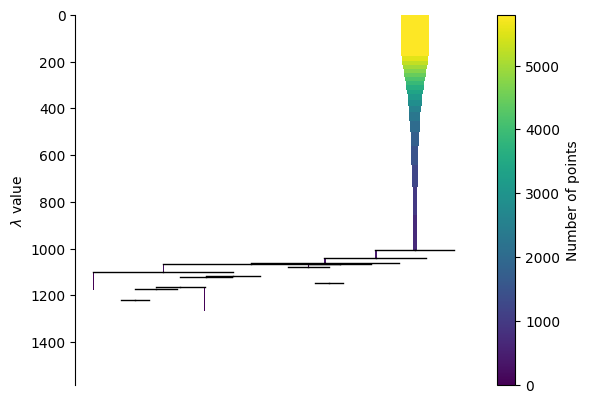

In [249]:
cluster.condensed_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

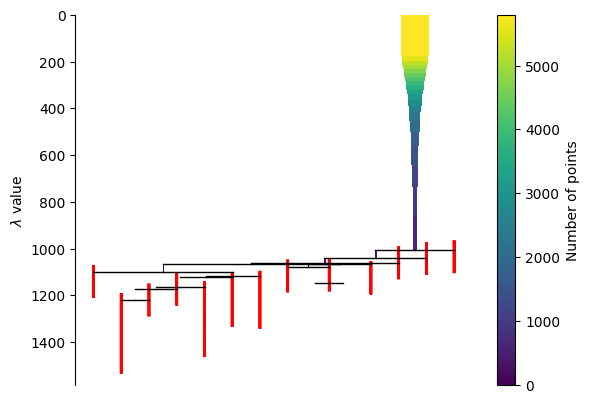

In [250]:
cluster.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

In [251]:
g = cluster.condensed_tree_.to_networkx()
g.number_of_nodes()

5821

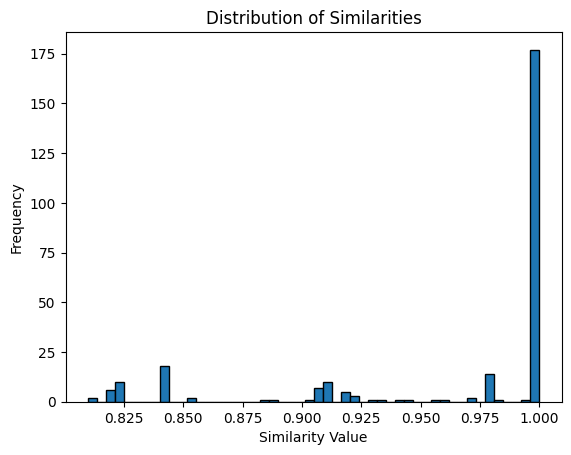

In [252]:
plt.hist(cluster.probabilities_[np.where(cluster.probabilities_>0)], bins=50, edgecolor='k')
plt.xlabel('Similarity Value')
plt.ylabel('Frequency')
plt.title('Distribution of Similarities')
plt.show()

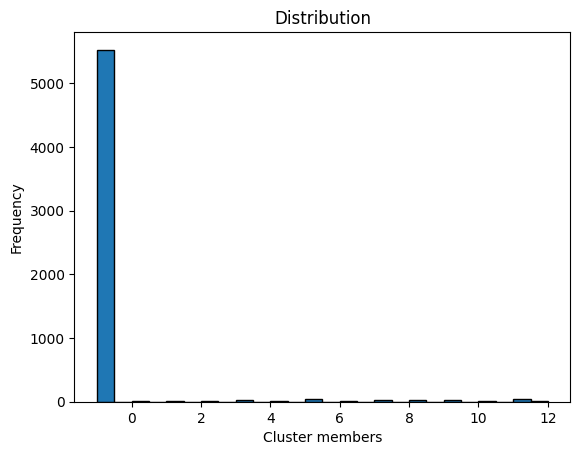

In [253]:
plt.hist(cluster.labels_, bins=26, edgecolor='k')
plt.xlabel('Cluster members')
plt.ylabel('Frequency')
plt.title('Distribution')
plt.show()

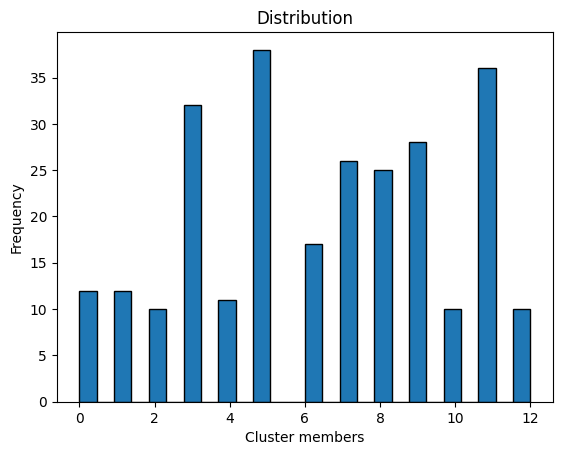

In [254]:
plt.hist(cluster.labels_[np.where(cluster.labels_>-1)], bins=26, edgecolor='k')
plt.xlabel('Cluster members')
plt.ylabel('Frequency')
plt.title('Distribution')
plt.show()

(5794, 64)
(1, 26, 64)
(1, 64)


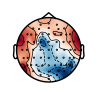

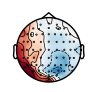

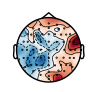

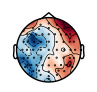

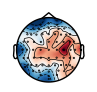

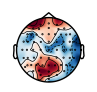

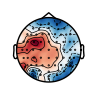

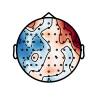

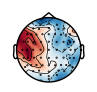

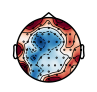

(<matplotlib.image.AxesImage at 0x2f6b5759e40>,
 <matplotlib.contour.QuadContourSet at 0x2f6b575a1d0>)

In [266]:
c26_indexes = np.where(cluster.labels_==7)
print(normalized.shape)
c26_gfp = normalized[c26_indexes, :]
print(c26_gfp.shape)
c26_gfp.reshape((26, 64))
print(c26_gfp[:, 0].shape)
mne.viz.plot_topomap(c26_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 10].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 20].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 21].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 22].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 5].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 2].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 15].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 25].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 14].flatten(), pos=raw.info)


(5794, 64)
(1, 28, 64)
(1, 64)


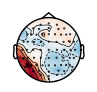

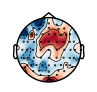

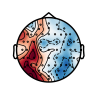

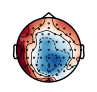

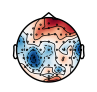

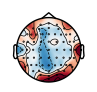

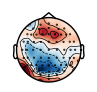

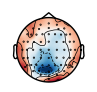

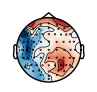

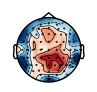

(<matplotlib.image.AxesImage at 0x2f6b62cd180>,
 <matplotlib.contour.QuadContourSet at 0x2f6b6a254e0>)

In [268]:
c26_indexes = np.where(cluster.labels_==9)
print(normalized.shape)
c26_gfp = normalized[c26_indexes, :]
print(c26_gfp.shape)
c26_gfp.reshape((28, 64))
print(c26_gfp[:, 0].shape)
mne.viz.plot_topomap(c26_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 10].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 20].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 21].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 22].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 5].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 2].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 15].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 25].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 14].flatten(), pos=raw.info)

(5794, 64)
(1, 32, 64)
(1, 64)


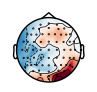

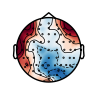

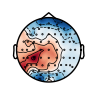

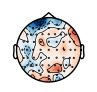

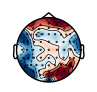

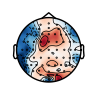

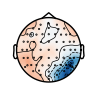

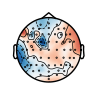

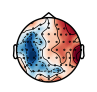

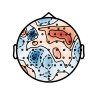

(<matplotlib.image.AxesImage at 0x2f6b54efac0>,
 <matplotlib.contour.QuadContourSet at 0x2f6b54ef400>)

In [270]:
c26_indexes = np.where(cluster.labels_==3)
print(normalized.shape)
c26_gfp = normalized[c26_indexes, :]
print(c26_gfp.shape)
c26_gfp.reshape((32, 64))
print(c26_gfp[:, 0].shape)
mne.viz.plot_topomap(c26_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 10].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 20].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 21].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 22].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 5].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 2].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 15].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 25].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 14].flatten(), pos=raw.info)

(5794, 64)
(1, 38, 64)
(1, 64)


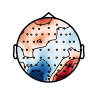

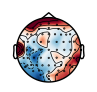

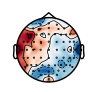

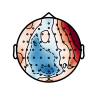

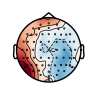

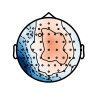

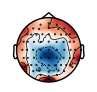

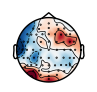

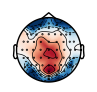

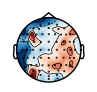

(<matplotlib.image.AxesImage at 0x2f6b7767f10>,
 <matplotlib.contour.QuadContourSet at 0x2f6b7765960>)

In [272]:
c26_indexes = np.where(cluster.labels_==5)
print(normalized.shape)
c26_gfp = normalized[c26_indexes, :]
print(c26_gfp.shape)
c26_gfp.reshape((38, 64))
print(c26_gfp[:, 0].shape)
mne.viz.plot_topomap(c26_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 10].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 20].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 21].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 22].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 5].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 2].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 15].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 25].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 14].flatten(), pos=raw.info)

(5794, 64)
(1, 36, 64)
(1, 64)


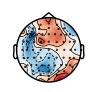

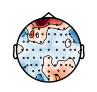

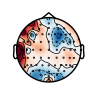

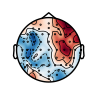

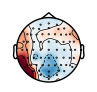

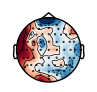

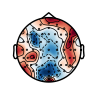

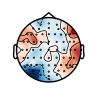

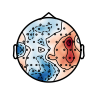

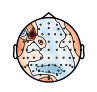

(<matplotlib.image.AxesImage at 0x2f6b631c550>,
 <matplotlib.contour.QuadContourSet at 0x2f6b631e680>)

In [276]:
c26_indexes = np.where(cluster.labels_==11)
print(normalized.shape)
c26_gfp = normalized[c26_indexes, :]
print(c26_gfp.shape)
c26_gfp.reshape((36, 64))
print(c26_gfp[:, 0].shape)
mne.viz.plot_topomap(c26_gfp[:, 0].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 10].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 20].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 21].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 22].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 5].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 2].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 15].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 25].flatten(), pos=raw.info)
mne.viz.plot_topomap(c26_gfp[:, 14].flatten(), pos=raw.info)